In [1]:
import pandas as pd

In [2]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import root_mean_squared_error

In [5]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2024/05/16 19:42:03 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/05/16 19:42:03 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/Week2/mlruns/1', creation_time=1715888525923, experiment_id='1', last_update_time=1715888525923, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [6]:
df = pd.read_parquet('./data/green_tripdata_2023-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.060351536580523

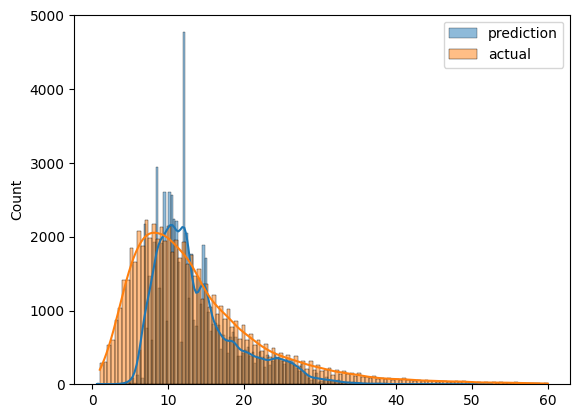

In [8]:
sns.histplot(y_pred, label='prediction', kde=True)
sns.histplot(y_train, label='actual', kde=True)

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('./data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2023-02.parquet')

In [11]:
len(df_train), len(df_val)

(65946, 62574)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

6.037803764245777

In [16]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "cecile")
    mlflow.log_param("train-data-path", "./data/green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2023-02.parquet")
    
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

In [19]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [20]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [27]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag("developer", "cecile")
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)
        
        return {"loss": rmse, "status": STATUS_OK}

In [28]:
# http://hyperopt.github.io/hyperopt/getting-started/search_spaces/
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:squarederror',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:00:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.57946                           
[1]	validation-rmse:6.57508                           
[2]	validation-rmse:6.02344                           
[3]	validation-rmse:5.73218                           
[4]	validation-rmse:5.57464                           
[5]	validation-rmse:5.49342                           
[6]	validation-rmse:5.44049                           
[7]	validation-rmse:5.40337                           
[8]	validation-rmse:5.37960                           
[9]	validation-rmse:5.36434                           
[10]	validation-rmse:5.35396                          
[11]	validation-rmse:5.34162                          
[12]	validation-rmse:5.33580                          
[13]	validation-rmse:5.32971                          
[14]	validation-rmse:5.32155                          
[15]	validation-rmse:5.31505                          
[16]	validation-rmse:5.31286                          
[17]	validation-rmse:5.31049                          
[18]	valid

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:01:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.42589                                                    
[1]	validation-rmse:7.70499                                                    
[2]	validation-rmse:7.13152                                                    
[3]	validation-rmse:6.67888                                                    
[4]	validation-rmse:6.32479                                                    
[5]	validation-rmse:6.04965                                                    
[6]	validation-rmse:5.84326                                                    
[7]	validation-rmse:5.68059                                                    
[8]	validation-rmse:5.55723                                                    
[9]	validation-rmse:5.46893                                                    
[10]	validation-rmse:5.39979                                                   
[11]	validation-rmse:5.34707                                                   
[12]	validation-rmse:5.30666            

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:02:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.43570                                                    
[1]	validation-rmse:6.35546                                                    
[2]	validation-rmse:5.77276                                                    
[3]	validation-rmse:5.47676                                                    
[4]	validation-rmse:5.32984                                                    
[5]	validation-rmse:5.25600                                                    
[6]	validation-rmse:5.21817                                                    
[7]	validation-rmse:5.19821                                                    
[8]	validation-rmse:5.18948                                                    
[9]	validation-rmse:5.18329                                                    
[10]	validation-rmse:5.17930                                                   
[11]	validation-rmse:5.17725                                                   
[12]	validation-rmse:5.17726            

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:03:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.26821                                                    
[1]	validation-rmse:7.47107                                                    
[2]	validation-rmse:6.87915                                                    
[3]	validation-rmse:6.44567                                                    
[4]	validation-rmse:6.13192                                                    
[5]	validation-rmse:5.90909                                                    
[6]	validation-rmse:5.74899                                                    
[7]	validation-rmse:5.63400                                                    
[8]	validation-rmse:5.55410                                                    
[9]	validation-rmse:5.49199                                                    
[10]	validation-rmse:5.45039                                                   
[11]	validation-rmse:5.41833                                                   
[12]	validation-rmse:5.39276            

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:04:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.49650                                                    
[1]	validation-rmse:5.46537                                                    
[2]	validation-rmse:5.44358                                                    
[3]	validation-rmse:5.42708                                                    
[4]	validation-rmse:5.41224                                                    
[5]	validation-rmse:5.40607                                                    
[6]	validation-rmse:5.39999                                                    
[7]	validation-rmse:5.39281                                                    
[8]	validation-rmse:5.38811                                                    
[9]	validation-rmse:5.36498                                                    
[10]	validation-rmse:5.36034                                                   
[11]	validation-rmse:5.35531                                                   
[12]	validation-rmse:5.34550            

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:05:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.84839                                                    
[1]	validation-rmse:5.83200                                                    
[2]	validation-rmse:5.45433                                                    
[3]	validation-rmse:5.30977                                                    
[4]	validation-rmse:5.24819                                                    
[5]	validation-rmse:5.22284                                                    
[6]	validation-rmse:5.20529                                                    
[7]	validation-rmse:5.19460                                                    
[8]	validation-rmse:5.18745                                                    
[9]	validation-rmse:5.18308                                                    
[10]	validation-rmse:5.17971                                                   
[11]	validation-rmse:5.17753                                                   
[12]	validation-rmse:5.17712            

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:05:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.92831                                                    
[1]	validation-rmse:8.56800                                                    
[2]	validation-rmse:8.23969                                                    
[3]	validation-rmse:7.94072                                                    
[4]	validation-rmse:7.66830                                                    
[5]	validation-rmse:7.42140                                                    
[6]	validation-rmse:7.19789                                                    
[7]	validation-rmse:6.99611                                                    
[8]	validation-rmse:6.81412                                                    
[9]	validation-rmse:6.65015                                                    
[10]	validation-rmse:6.50269                                                   
[11]	validation-rmse:6.37057                                                   
[12]	validation-rmse:6.25269            

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:08:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.85241                                                      
[1]	validation-rmse:8.42959                                                      
[2]	validation-rmse:8.04991                                                      
[3]	validation-rmse:7.70993                                                      
[4]	validation-rmse:7.40629                                                      
[5]	validation-rmse:7.13647                                                      
[6]	validation-rmse:6.89685                                                      
[7]	validation-rmse:6.68517                                                      
[8]	validation-rmse:6.49807                                                      
[9]	validation-rmse:6.33297                                                      
[10]	validation-rmse:6.18778                                                     
[11]	validation-rmse:6.05958                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:10:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.98844                                                       
[1]	validation-rmse:8.68002                                                       
[2]	validation-rmse:8.39533                                                       
[3]	validation-rmse:8.13289                                                       
[4]	validation-rmse:7.89120                                                       
[5]	validation-rmse:7.66918                                                       
[6]	validation-rmse:7.46533                                                       
[7]	validation-rmse:7.27855                                                       
[8]	validation-rmse:7.10774                                                       
[9]	validation-rmse:6.95154                                                       
[10]	validation-rmse:6.80899                                                      
[11]	validation-rmse:6.67887                                                      
[12]

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:15:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.98137                                                       
[1]	validation-rmse:5.44654                                                       
[2]	validation-rmse:5.33705                                                       
[3]	validation-rmse:5.30429                                                       
[4]	validation-rmse:5.28798                                                       
[5]	validation-rmse:5.27258                                                       
[6]	validation-rmse:5.27265                                                       
[7]	validation-rmse:5.25343                                                       
[8]	validation-rmse:5.25148                                                       
[9]	validation-rmse:5.24632                                                       
[10]	validation-rmse:5.24403                                                      
[11]	validation-rmse:5.24028                                                      
[12]

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:16:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.54320                                                        
[1]	validation-rmse:5.32341                                                        
[2]	validation-rmse:5.30754                                                        
[3]	validation-rmse:5.30501                                                        
[4]	validation-rmse:5.30256                                                        
[5]	validation-rmse:5.29302                                                        
[6]	validation-rmse:5.28677                                                        
[7]	validation-rmse:5.28702                                                        
[8]	validation-rmse:5.28641                                                        
[9]	validation-rmse:5.28175                                                        
[10]	validation-rmse:5.27734                                                       
[11]	validation-rmse:5.27796                                                

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:16:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.33047                                                     
[1]	validation-rmse:7.55829                                                     
[2]	validation-rmse:6.98182                                                     
[3]	validation-rmse:6.51745                                                     
[4]	validation-rmse:6.19578                                                     
[5]	validation-rmse:5.95116                                                     
[6]	validation-rmse:5.77757                                                     
[7]	validation-rmse:5.65034                                                     
[8]	validation-rmse:5.55421                                                     
[9]	validation-rmse:5.47929                                                     
[10]	validation-rmse:5.42740                                                    
[11]	validation-rmse:5.39424                                                    
[12]	validation-rmse:5.35961

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:17:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.73228                                                     
[1]	validation-rmse:5.44045                                                     
[2]	validation-rmse:5.37906                                                     
[3]	validation-rmse:5.35067                                                     
[4]	validation-rmse:5.32838                                                     
[5]	validation-rmse:5.32089                                                     
[6]	validation-rmse:5.31607                                                     
[7]	validation-rmse:5.31171                                                     
[8]	validation-rmse:5.31179                                                     
[9]	validation-rmse:5.30666                                                     
[10]	validation-rmse:5.30394                                                    
[11]	validation-rmse:5.29544                                                    
[12]	validation-rmse:5.29411

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:18:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.52953                                                     
[1]	validation-rmse:5.23510                                                     
[2]	validation-rmse:5.21114                                                     
[3]	validation-rmse:5.20615                                                     
[4]	validation-rmse:5.20259                                                     
[5]	validation-rmse:5.20120                                                     
[6]	validation-rmse:5.19884                                                     
[7]	validation-rmse:5.19820                                                     
[8]	validation-rmse:5.19596                                                     
[9]	validation-rmse:5.18650                                                     
[10]	validation-rmse:5.18637                                                    
[11]	validation-rmse:5.18443                                                    
[12]	validation-rmse:5.18674

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:18:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.41946                                                     
[1]	validation-rmse:5.33207                                                     
[2]	validation-rmse:5.32375                                                     
[3]	validation-rmse:5.30439                                                     
[4]	validation-rmse:5.29432                                                     
[5]	validation-rmse:5.28672                                                     
[6]	validation-rmse:5.28009                                                     
[7]	validation-rmse:5.26285                                                     
[8]	validation-rmse:5.25570                                                     
[9]	validation-rmse:5.25269                                                     
[10]	validation-rmse:5.24644                                                    
[11]	validation-rmse:5.24522                                                    
[12]	validation-rmse:5.24339

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:18:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.52822                                                     
[1]	validation-rmse:5.24516                                                     
[2]	validation-rmse:5.22430                                                     
[3]	validation-rmse:5.21677                                                     
[4]	validation-rmse:5.20826                                                     
[5]	validation-rmse:5.19574                                                     
[6]	validation-rmse:5.19002                                                     
[7]	validation-rmse:5.18823                                                     
[8]	validation-rmse:5.18631                                                     
[9]	validation-rmse:5.18236                                                     
[10]	validation-rmse:5.18575                                                    
[11]	validation-rmse:5.18227                                                    
[12]	validation-rmse:5.18286

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:19:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.00997                                                     
[1]	validation-rmse:8.72054                                                     
[2]	validation-rmse:8.45088                                                     
[3]	validation-rmse:8.20204                                                     
[4]	validation-rmse:7.96879                                                     
[5]	validation-rmse:7.75295                                                     
[6]	validation-rmse:7.55377                                                     
[7]	validation-rmse:7.36544                                                     
[8]	validation-rmse:7.19586                                                     
[9]	validation-rmse:7.03671                                                     
[10]	validation-rmse:6.89214                                                    
[11]	validation-rmse:6.75916                                                    
[12]	validation-rmse:6.63693

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:21:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.89920                                                     
[1]	validation-rmse:6.94469                                                     
[2]	validation-rmse:6.34196                                                     
[3]	validation-rmse:5.94061                                                     
[4]	validation-rmse:5.69127                                                     
[5]	validation-rmse:5.54232                                                     
[6]	validation-rmse:5.44685                                                     
[7]	validation-rmse:5.39533                                                     
[8]	validation-rmse:5.35724                                                     
[9]	validation-rmse:5.33961                                                     
[10]	validation-rmse:5.31712                                                    
[11]	validation-rmse:5.30422                                                    
[12]	validation-rmse:5.29527

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:22:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.93469                                                     
[1]	validation-rmse:6.99011                                                     
[2]	validation-rmse:6.36784                                                     
[3]	validation-rmse:5.96417                                                     
[4]	validation-rmse:5.70937                                                     
[5]	validation-rmse:5.55029                                                     
[6]	validation-rmse:5.44539                                                     
[7]	validation-rmse:5.37783                                                     
[8]	validation-rmse:5.33557                                                     
[9]	validation-rmse:5.30454                                                     
[10]	validation-rmse:5.28239                                                    
[11]	validation-rmse:5.26303                                                    
[12]	validation-rmse:5.25181

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:23:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.48715                                                     
[1]	validation-rmse:6.46450                                                     
[2]	validation-rmse:5.92802                                                     
[3]	validation-rmse:5.65621                                                     
[4]	validation-rmse:5.51128                                                     
[5]	validation-rmse:5.43787                                                     
[6]	validation-rmse:5.39353                                                     
[7]	validation-rmse:5.36249                                                     
[8]	validation-rmse:5.34284                                                     
[9]	validation-rmse:5.32770                                                     
[10]	validation-rmse:5.31781                                                    
[11]	validation-rmse:5.31233                                                    
[12]	validation-rmse:5.30598

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:24:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.75430                                                     
[1]	validation-rmse:8.25615                                                     
[2]	validation-rmse:7.82087                                                     
[3]	validation-rmse:7.44153                                                     
[4]	validation-rmse:7.11244                                                     
[5]	validation-rmse:6.82781                                                     
[6]	validation-rmse:6.58313                                                     
[7]	validation-rmse:6.37378                                                     
[8]	validation-rmse:6.19488                                                     
[9]	validation-rmse:6.04276                                                     
[10]	validation-rmse:5.91346                                                    
[11]	validation-rmse:5.80412                                                    
[12]	validation-rmse:5.71174

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:26:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.87959                                                     
[1]	validation-rmse:5.91843                                                     
[2]	validation-rmse:5.55490                                                     
[3]	validation-rmse:5.41882                                                     
[4]	validation-rmse:5.36220                                                     
[5]	validation-rmse:5.33677                                                     
[6]	validation-rmse:5.32486                                                     
[7]	validation-rmse:5.31810                                                     
[8]	validation-rmse:5.31678                                                     
[9]	validation-rmse:5.31153                                                     
[10]	validation-rmse:5.30675                                                    
[11]	validation-rmse:5.30043                                                    
[12]	validation-rmse:5.29597

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:26:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.44086                                                     
[1]	validation-rmse:5.57523                                                     
[2]	validation-rmse:5.33749                                                     
[3]	validation-rmse:5.26030                                                     
[4]	validation-rmse:5.22855                                                     
[5]	validation-rmse:5.21763                                                     
[6]	validation-rmse:5.20543                                                     
[7]	validation-rmse:5.20118                                                     
[8]	validation-rmse:5.19179                                                     
[9]	validation-rmse:5.18756                                                     
[10]	validation-rmse:5.18567                                                    
[11]	validation-rmse:5.18343                                                    
[12]	validation-rmse:5.18134

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:27:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.67234                                                     
[1]	validation-rmse:8.11698                                                     
[2]	validation-rmse:7.64201                                                     
[3]	validation-rmse:7.24051                                                     
[4]	validation-rmse:6.90074                                                     
[5]	validation-rmse:6.61709                                                     
[6]	validation-rmse:6.37924                                                     
[7]	validation-rmse:6.18062                                                     
[8]	validation-rmse:6.01722                                                     
[9]	validation-rmse:5.88213                                                     
[10]	validation-rmse:5.76966                                                    
[11]	validation-rmse:5.67627                                                    
[12]	validation-rmse:5.59848

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:28:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.46260                                                     
[4]	validation-rmse:7.15261                                                     
[5]	validation-rmse:6.89195                                                     
[6]	validation-rmse:6.66890                                                     
[7]	validation-rmse:6.48128                                                     
[8]	validation-rmse:6.32354                                                     
[9]	validation-rmse:6.19246                                                     
[10]	validation-rmse:6.08197                                                    
[11]	validation-rmse:5.98934                                                    
[12]	validation-rmse:5.91284                                                    
[13]	validation-rmse:5.85029                                                    
[14]	validation-rmse:5.79475                                                    
[15]	validation-rmse:5.75137

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:29:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.37915                                                     
[5]	validation-rmse:7.12465                                                     
[6]	validation-rmse:6.90389                                                     
[7]	validation-rmse:6.71433                                                     
[8]	validation-rmse:6.55097                                                     
[9]	validation-rmse:6.40953                                                     
[10]	validation-rmse:6.28644                                                    
[11]	validation-rmse:6.18262                                                    
[12]	validation-rmse:6.09203                                                    
[13]	validation-rmse:6.01525                                                    
[14]	validation-rmse:5.94817                                                    
[15]	validation-rmse:5.89169                                                    
[16]	validation-rmse:5.84419

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:29:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.65140                                                     
[1]	validation-rmse:8.08405                                                     
[2]	validation-rmse:7.60554                                                     
[3]	validation-rmse:7.20756                                                     
[4]	validation-rmse:6.87332                                                     
[5]	validation-rmse:6.59396                                                     
[6]	validation-rmse:6.36780                                                     
[7]	validation-rmse:6.17962                                                     
[8]	validation-rmse:6.02203                                                     
[9]	validation-rmse:5.89628                                                     
[10]	validation-rmse:5.79666                                                    
[11]	validation-rmse:5.71041                                                    
[12]	validation-rmse:5.64528

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:31:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.89731                                                     
[1]	validation-rmse:8.51211                                                     
[2]	validation-rmse:8.16420                                                     
[3]	validation-rmse:7.84826                                                     
[4]	validation-rmse:7.56579                                                     
[5]	validation-rmse:7.31059                                                     
[6]	validation-rmse:7.08221                                                     
[7]	validation-rmse:6.87608                                                     
[8]	validation-rmse:6.69194                                                     
[9]	validation-rmse:6.52892                                                     
[10]	validation-rmse:6.38212                                                    
[11]	validation-rmse:6.25373                                                    
[12]	validation-rmse:6.13568

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:33:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.58492                                                     
[1]	validation-rmse:7.96474                                                     
[2]	validation-rmse:7.44557                                                     
[3]	validation-rmse:7.01674                                                     
[4]	validation-rmse:6.66398                                                     
[5]	validation-rmse:6.37453                                                     
[6]	validation-rmse:6.14002                                                     
[7]	validation-rmse:5.95082                                                     
[8]	validation-rmse:5.79791                                                     
[9]	validation-rmse:5.67460                                                     
[10]	validation-rmse:5.57636                                                    
[11]	validation-rmse:5.49724                                                    
[12]	validation-rmse:5.43404

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:34:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.49317                                                     
[1]	validation-rmse:7.81075                                                     
[2]	validation-rmse:7.25273                                                     
[3]	validation-rmse:6.80346                                                     
[4]	validation-rmse:6.44436                                                     
[5]	validation-rmse:6.16001                                                     
[6]	validation-rmse:5.93785                                                     
[7]	validation-rmse:5.76332                                                     
[8]	validation-rmse:5.62906                                                     
[9]	validation-rmse:5.52399                                                     
[10]	validation-rmse:5.44395                                                    
[11]	validation-rmse:5.38237                                                    
[12]	validation-rmse:5.33539

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:35:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.87284                                                     
[1]	validation-rmse:8.46668                                                     
[2]	validation-rmse:8.10162                                                     
[3]	validation-rmse:7.77397                                                     
[4]	validation-rmse:7.47965                                                     
[5]	validation-rmse:7.21569                                                     
[6]	validation-rmse:6.98114                                                     
[7]	validation-rmse:6.77001                                                     
[8]	validation-rmse:6.58349                                                     
[9]	validation-rmse:6.41909                                                     
[10]	validation-rmse:6.27045                                                    
[11]	validation-rmse:6.14267                                                    
[12]	validation-rmse:6.02646

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:37:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.49792                                                     
[1]	validation-rmse:7.82325                                                     
[2]	validation-rmse:7.27559                                                     
[3]	validation-rmse:6.83555                                                     
[4]	validation-rmse:6.48611                                                     
[5]	validation-rmse:6.20942                                                     
[6]	validation-rmse:5.99294                                                     
[7]	validation-rmse:5.82355                                                     
[8]	validation-rmse:5.69167                                                     
[9]	validation-rmse:5.59074                                                     
[10]	validation-rmse:5.51201                                                    
[11]	validation-rmse:5.44995                                                    
[12]	validation-rmse:5.39939

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:39:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.22388                                                     
[1]	validation-rmse:7.39051                                                     
[2]	validation-rmse:6.76950                                                     
[3]	validation-rmse:6.31533                                                     
[4]	validation-rmse:5.98729                                                     
[5]	validation-rmse:5.75030                                                     
[6]	validation-rmse:5.58217                                                     
[7]	validation-rmse:5.46455                                                     
[8]	validation-rmse:5.38320                                                     
[9]	validation-rmse:5.32551                                                     
[10]	validation-rmse:5.28204                                                    
[11]	validation-rmse:5.25246                                                    
[12]	validation-rmse:5.23133

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:40:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.83483                                                     
[1]	validation-rmse:8.39918                                                     
[2]	validation-rmse:8.01525                                                     
[3]	validation-rmse:7.66726                                                     
[4]	validation-rmse:7.36394                                                     
[5]	validation-rmse:7.09903                                                     
[6]	validation-rmse:6.85777                                                     
[7]	validation-rmse:6.65341                                                     
[8]	validation-rmse:6.47351                                                     
[9]	validation-rmse:6.32106                                                     
[10]	validation-rmse:6.17299                                                    
[11]	validation-rmse:6.05821                                                    
[12]	validation-rmse:5.95687

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:42:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.09478                                                      
[1]	validation-rmse:7.19757                                                      
[2]	validation-rmse:6.56147                                                      
[3]	validation-rmse:6.11721                                                      
[4]	validation-rmse:5.81611                                                      
[5]	validation-rmse:5.60245                                                      
[6]	validation-rmse:5.46576                                                      
[7]	validation-rmse:5.37240                                                      
[8]	validation-rmse:5.30928                                                      
[9]	validation-rmse:5.27035                                                      
[10]	validation-rmse:5.24032                                                     
[11]	validation-rmse:5.21957                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:43:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.96666                                                     
[1]	validation-rmse:8.63896                                                     
[2]	validation-rmse:8.33741                                                     
[3]	validation-rmse:8.06000                                                     
[4]	validation-rmse:7.80550                                                     
[5]	validation-rmse:7.57255                                                     
[6]	validation-rmse:7.35940                                                     
[7]	validation-rmse:7.16473                                                     
[8]	validation-rmse:6.98715                                                     
[9]	validation-rmse:6.82555                                                     
[10]	validation-rmse:6.67859                                                    
[11]	validation-rmse:6.54518                                                    
[12]	validation-rmse:6.42376

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:46:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.57684                                                      
[1]	validation-rmse:7.95373                                                      
[2]	validation-rmse:7.43660                                                      
[3]	validation-rmse:7.00984                                                      
[4]	validation-rmse:6.66128                                                      
[5]	validation-rmse:6.37885                                                      
[6]	validation-rmse:6.15043                                                      
[7]	validation-rmse:5.96677                                                      
[8]	validation-rmse:5.81968                                                      
[9]	validation-rmse:5.70308                                                      
[10]	validation-rmse:5.60972                                                     
[11]	validation-rmse:5.53521                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.81307                                                      
[1]	validation-rmse:6.84509                                                      
[2]	validation-rmse:6.24792                                                      
[3]	validation-rmse:5.88897                                                      
[4]	validation-rmse:5.67949                                                      
[5]	validation-rmse:5.55151                                                      
[6]	validation-rmse:5.47284                                                      
[7]	validation-rmse:5.42535                                                      
[8]	validation-rmse:5.39171                                                      
[9]	validation-rmse:5.36387                                                      
[10]	validation-rmse:5.34941                                                     
[11]	validation-rmse:5.33651                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:49:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.42013                                                     
[1]	validation-rmse:7.69381                                                     
[2]	validation-rmse:7.11509                                                     
[3]	validation-rmse:6.65834                                                     
[4]	validation-rmse:6.30407                                                     
[5]	validation-rmse:6.03046                                                     
[6]	validation-rmse:5.82135                                                     
[7]	validation-rmse:5.66422                                                     
[8]	validation-rmse:5.54423                                                     
[9]	validation-rmse:5.45322                                                     
[10]	validation-rmse:5.38450                                                    
[11]	validation-rmse:5.33270                                                    
[12]	validation-rmse:5.29358

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:50:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99095                                                     
[1]	validation-rmse:8.68296                                                     
[2]	validation-rmse:8.39694                                                     
[3]	validation-rmse:8.13123                                                     
[4]	validation-rmse:7.88499                                                     
[5]	validation-rmse:7.65716                                                     
[6]	validation-rmse:7.44674                                                     
[7]	validation-rmse:7.25243                                                     
[8]	validation-rmse:7.07346                                                     
[9]	validation-rmse:6.90895                                                     
[10]	validation-rmse:6.75740                                                    
[11]	validation-rmse:6.61858                                                    
[12]	validation-rmse:6.49144

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:53:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.34984                                                      
[1]	validation-rmse:6.27648                                                      
[2]	validation-rmse:5.71808                                                      
[3]	validation-rmse:5.45159                                                      
[4]	validation-rmse:5.31316                                                      
[5]	validation-rmse:5.25096                                                      
[6]	validation-rmse:5.21472                                                      
[7]	validation-rmse:5.19489                                                      
[8]	validation-rmse:5.18226                                                      
[9]	validation-rmse:5.17287                                                      
[10]	validation-rmse:5.16686                                                     
[11]	validation-rmse:5.16405                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:54:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.35529                                                     
[1]	validation-rmse:7.59778                                                     
[2]	validation-rmse:7.01012                                                     
[3]	validation-rmse:6.56132                                                     
[4]	validation-rmse:6.22334                                                     
[5]	validation-rmse:5.97213                                                     
[6]	validation-rmse:5.78546                                                     
[7]	validation-rmse:5.64771                                                     
[8]	validation-rmse:5.54577                                                     
[9]	validation-rmse:5.46993                                                     
[10]	validation-rmse:5.41069                                                    
[11]	validation-rmse:5.36891                                                    
[12]	validation-rmse:5.33619

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:55:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.84355                                                     
[1]	validation-rmse:8.41699                                                     
[2]	validation-rmse:8.03903                                                     
[3]	validation-rmse:7.69938                                                     
[4]	validation-rmse:7.39911                                                     
[5]	validation-rmse:7.13208                                                     
[6]	validation-rmse:6.90048                                                     
[7]	validation-rmse:6.69094                                                     
[8]	validation-rmse:6.51349                                                     
[9]	validation-rmse:6.35242                                                     
[10]	validation-rmse:6.21531                                                    
[11]	validation-rmse:6.09718                                                    
[12]	validation-rmse:5.99033

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:56:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.95510                                                     
[1]	validation-rmse:8.61886                                                     
[2]	validation-rmse:8.31129                                                     
[3]	validation-rmse:8.03043                                                     
[4]	validation-rmse:7.77441                                                     
[5]	validation-rmse:7.54159                                                     
[6]	validation-rmse:7.33007                                                     
[7]	validation-rmse:7.13829                                                     
[8]	validation-rmse:6.96466                                                     
[9]	validation-rmse:6.80782                                                     
[10]	validation-rmse:6.66626                                                    
[11]	validation-rmse:6.53811                                                    
[12]	validation-rmse:6.42327

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:59:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.76970                                                      
[1]	validation-rmse:8.28142                                                      
[2]	validation-rmse:7.85134                                                      
[3]	validation-rmse:7.47450                                                      
[4]	validation-rmse:7.14500                                                      
[5]	validation-rmse:6.85838                                                      
[6]	validation-rmse:6.61088                                                      
[7]	validation-rmse:6.39602                                                      
[8]	validation-rmse:6.21244                                                      
[9]	validation-rmse:6.05516                                                      
[10]	validation-rmse:5.91996                                                     
[11]	validation-rmse:5.80640                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:01:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.70296                                                        
[1]	validation-rmse:6.70104                                                        
[2]	validation-rmse:6.10440                                                        
[3]	validation-rmse:5.75919                                                        
[4]	validation-rmse:5.56333                                                        
[5]	validation-rmse:5.44973                                                        
[6]	validation-rmse:5.38679                                                        
[7]	validation-rmse:5.34680                                                        
[8]	validation-rmse:5.31774                                                        
[9]	validation-rmse:5.30288                                                        
[10]	validation-rmse:5.29170                                                       
[11]	validation-rmse:5.28117                                                

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:02:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.04479                                                       
[1]	validation-rmse:7.13194                                                       
[2]	validation-rmse:6.49616                                                       
[3]	validation-rmse:6.06362                                                       
[4]	validation-rmse:5.77539                                                       
[5]	validation-rmse:5.58535                                                       
[6]	validation-rmse:5.46056                                                       
[7]	validation-rmse:5.37530                                                       
[8]	validation-rmse:5.31785                                                       
[9]	validation-rmse:5.28073                                                       
[10]	validation-rmse:5.25483                                                      
[11]	validation-rmse:5.23847                                                      
[12]

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:02:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.38808                                                       
[1]	validation-rmse:7.65399                                                       
[2]	validation-rmse:7.08610                                                       
[3]	validation-rmse:6.65127                                                       
[4]	validation-rmse:6.32115                                                       
[5]	validation-rmse:6.07329                                                       
[6]	validation-rmse:5.88831                                                       
[7]	validation-rmse:5.75080                                                       
[8]	validation-rmse:5.64870                                                       
[9]	validation-rmse:5.57323                                                       
[10]	validation-rmse:5.51259                                                      
[11]	validation-rmse:5.46942                                                      
[12]

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:04:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.60963                                                       
[1]	validation-rmse:8.00885                                                       
[2]	validation-rmse:7.50452                                                       
[3]	validation-rmse:7.08574                                                       
[4]	validation-rmse:6.73835                                                       
[5]	validation-rmse:6.45364                                                       
[6]	validation-rmse:6.21914                                                       
[7]	validation-rmse:6.02804                                                       
[8]	validation-rmse:5.87093                                                       
[9]	validation-rmse:5.74391                                                       
[10]	validation-rmse:5.64246                                                      
[11]	validation-rmse:5.55932                                                      
[12]

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:05:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.71173                                                        
[1]	validation-rmse:8.18776                                                        
[2]	validation-rmse:7.73503                                                        
[3]	validation-rmse:7.34778                                                        
[4]	validation-rmse:7.01838                                                        
[5]	validation-rmse:6.73747                                                        
[6]	validation-rmse:6.50215                                                        
[7]	validation-rmse:6.30111                                                        
[8]	validation-rmse:6.13646                                                        
[9]	validation-rmse:5.99925                                                        
[10]	validation-rmse:5.88530                                                       
[11]	validation-rmse:5.78303                                                

In [31]:
# https://mlflow.org/docs/latest/tracking/autolog.html
params = {
    'max_depth': 36,
    'learning_rate': 0.10, 
    'reg_alpha': 0.02,
    'reg_lambda': 0.20,
    'min_child_weight': 3,
    'objective': 'reg:squarederror',
    'seed': 42
}


mlflow.xgboost.autolog()

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

booster = xgb.train(
    params = params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)

2024/05/16 21:29:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '486b1a1e72fc4ec4bab42e0dbd9a33a4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:29:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.70697
[1]	validation-rmse:8.17547
[2]	validation-rmse:7.71652
[3]	validation-rmse:7.32394
[4]	validation-rmse:6.98670
[5]	validation-rmse:6.70197
[6]	validation-rmse:6.45899
[7]	validation-rmse:6.25476
[8]	validation-rmse:6.08385
[9]	validation-rmse:5.93988
[10]	validation-rmse:5.81975
[11]	validation-rmse:5.71968
[12]	validation-rmse:5.63612
[13]	validation-rmse:5.56528
[14]	validation-rmse:5.50546
[15]	validation-rmse:5.45725
[16]	validation-rmse:5.41673
[17]	validation-rmse:5.38148
[18]	validation-rmse:5.35253
[19]	validation-rmse:5.32882
[20]	validation-rmse:5.30819
[21]	validation-rmse:5.28991
[22]	validation-rmse:5.27536
[23]	validation-rmse:5.26245
[24]	validation-rmse:5.25175
[25]	validation-rmse:5.24183
[26]	validation-rmse:5.23423
[27]	validation-rmse:5.22841
[28]	validation-rmse:5.22224
[29]	validation-rmse:5.21617
[30]	validation-rmse:5.21224
[31]	validation-rmse:5.20807
[32]	validation-rmse:5.20282
[33]	validation-rmse:5.19973
[34]	validation-rmse:5.1

2024/05/16 21:30:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:30:33] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2024/05/16 21:30:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distuti